In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import ScalarFormatter, NullFormatter

plt.rcParams.update({'font.size': 14})
matplotlib.rcParams['xtick.minor.size'] = 0
matplotlib.rcParams['xtick.minor.width'] = 0

import sys
sys.path.append("..")

from ContrastEstimation import util, IntensityEstimation, ContrastEstimation, MoleculeZoo

# Define the Incident Beam

In [2]:
expParams = {}

# Photon energy and bandwidth
expParams['photon_energy_keV'] = 9.5  # Beam central photon energy in keV
expParams['bandwidth_keV'] = 0.4 * 1e-3 # Beam bandwidth in keV

# Beam size (focusing spot size)
expParams['beam_size_out_plane'] = 3.  # (um) Beam size on the sample perpendicular to the diffraction plane
expParams['beam_size_in_plane'] = 3.  # (um) Beam size on the sample within the diffraction plane

# Beam transverse coherence length (No need to change for LCLS beams)
expParams['trans_coh_length_out_plane'] = 30.  # (um) Beam coherence length perpendicular to the diffraction plane
expParams['trans_coh_length_in_plane'] = 30.  # (um) Beam coherence length within to the diffraction plane

# Detector pixel parameter
expParams['pixel_size'] = 50.0  # (um) detector pixel size

# Q value of interests
expParams['Q'] = 0.3 # 2 pi / length scale  # The unit is A^-1

# Scattering Geometry: Gamma = 0 means forward scattering, 1 for back scattering.
# Back scattering is only possible with crystal
expParams['gamma'] = 0.0

##########################################################
#                Parameters to scan.
##########################################################
expParams['sample_thickness'] = 50.  # (um) Sample thickness
expParams['detector_distance'] = 2.0  # (m) Detector distance

# Automatically calculate other quantities to facilicate the calculation
expParams = util.auto_update_expParams(expParams)

# Get the speckle contrast map

In [3]:
num = 100
holder = np.zeros((num, num, 5))

# thickness
thickness_list = np.logspace(1, 4, num)

# detector distances
distance_list = np.logspace(0, 1, num)

# Loop through all conditions
for idx1 in range(num):
    for idx2 in range(num):
        expParams['sample_thickness'] = thickness_list[idx1]
        expParams['detector_distance'] = distance_list[idx2]
        holder[idx1, idx2, :] = ContrastEstimation.get_contrast(expParams)
        
beta_map = holder[:,:,-1]

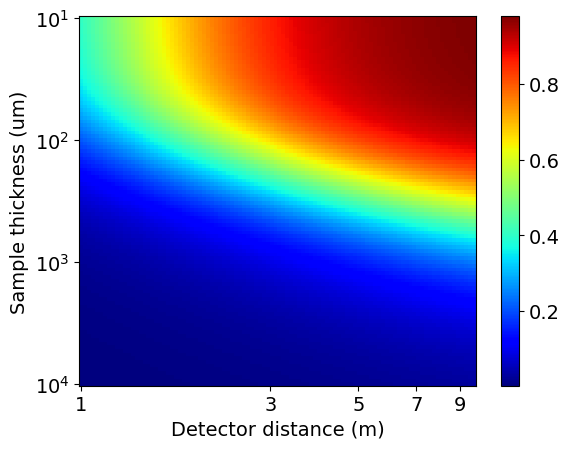

In [4]:
fig, axis = plt.subplots(ncols=1, nrows=1)

img1 = axis.imshow(beta_map,
                   aspect='auto',
                   cmap='jet')
axis.set_xlabel("Detector distance (m)")
axis.set_ylabel("Sample thickness (um)")

axis.set_xticks([100 * np.log10(2 * x + 1) for x in range(5)])
axis.set_xticklabels(["{}".format(2 * x + 1) for x in range(5)])
axis.set_yticks([33 * x for x in range(4)])
axis.set_yticklabels(["$10^{}$".format(x + 1) for x in range(4)])

fig.colorbar(img1, ax=axis)

plt.show()

# Get detector pixel number

In [5]:
pixel_num_holder = np.zeros(100)  # calculate the number of pixels within the range
for i,l in enumerate(distance_list):    
    q_map = ContrastEstimation.get_detector_q_map(theta0 = np.arcsin(expParams['Q'] /2. / expParams['incident_wavevec']),
                               n_pix = 1500,
                               pix_size = expParams['pixel_size'] / 1e6,
                               det_dist = l,
                               incident_wavevec_A = expParams['incident_wavevec'])
    pixel_num_holder[i] = ContrastEstimation.get_pixel_num_in_Q(q_map,
                                                  Q_min = expParams['Q'] * 0.97,
                                                  Q_max = expParams['Q'] * 1.03)

In [6]:
a, b = np.polyfit(x=distance_list, y=pixel_num_holder, deg = 1)
pixel_num_fit = a * distance_list + b

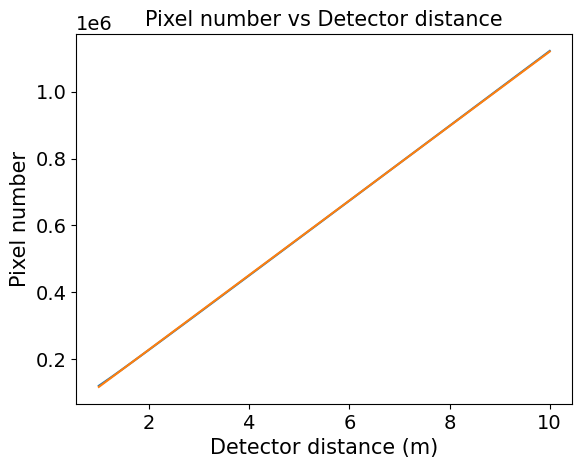

In [7]:
plt.plot(distance_list, pixel_num_holder)
plt.plot(distance_list, pixel_num_fit)

plt.xlabel("Detector distance (m)", fontsize=15)
plt.ylabel("Pixel number", fontsize=15)
plt.title("Pixel number vs Detector distance", fontsize=15)
plt.show()

# Calculate the Differential Cross Section

In [8]:
my_density = 0.273 # g / ml

my_molecule = MoleculeZoo.molecule_zoo['H2O']
atten_length = IntensityEstimation.get_attenuation_length_cm(molecule_structure=my_molecule,
                                                             photon_energy_keV=10,
                                                             density=my_density)
atten_length *= 1e-2

In [9]:
photon_energy = 9.5  # keV
I_in = 1e9  # incoming xray flux [photons/sec] at 14keV
l    = 1.6         # sample-to-detector distance [m]
p    = 50.0 *1e-6  # detector pixel size [m]
d    = 0.8  *1e-3  # sample thickness [m]

# solid angle covered by a single detector pixel
omega = (p / l)**2 

# Get effective sampe thickness
d_eff = d * np.exp( - d / atten_length)

# Get the scatterred intensity at the specified Q value
I_out = 0.015

# Get the cross section
diff_cross = I_out / (omega * d_eff * I_in) #  30 C

print('The differential cross section at 30 C is {:.2f} [1/m]'.format(diff_cross))

The differential cross section at 30 C is 21.57 [1/m]


# Get the estimated scattering intensity at LCLS

In [10]:
incident_pulse_energy = 10. * 5  # uJ
incident_pulse_energy_in_eV = incident_pulse_energy *  6241506479963.2

efficiency_per_branch = 0.03 # Transmission efficiency per branch of the split delay

photon_per_pulse = incident_pulse_energy_in_eV * efficiency_per_branch / (expParams['photon_energy_keV'] * 1000)   # photon number per branch per 
print("For each incident pulse, there are {:.2e} photons in each branch".format(photon_per_pulse))

For each incident pulse, there are 9.86e+08 photons in each branch


In [11]:
# Get the new attenuation
atten_length = IntensityEstimation.get_attenuation_length_cm(molecule_structure=my_molecule,
                                                             photon_energy_keV=expParams["photon_energy_keV"],
                                                             density=my_density)
atten_length *= 1e-2

inty_map = np.zeros((num, num)) #scattering intensity map

for idx1 in range(num):    
    for idx2 in range(num):
        
        #estimated scattering intensity on a single detector pixel [photons/pixels/shot]
        inty_map[idx1, idx2] = IntensityEstimation.get_scatter_intensity_with_differetial_crosssection(
            diff_cross_list = diff_cross,
            atten_length = atten_length,
            sample_thickness = thickness_list[idx1] * 1e-6,
            pixel_size = expParams['pixel_size'] * 1e-6,
            detector_distance = distance_list[idx2],
            incident_photon_count = photon_per_pulse)

print('done')

done


# Visualization

In [12]:
beta_map_2 = np.copy(beta_map)
#beta_map_2[beta_map_2<0.01] = 0.

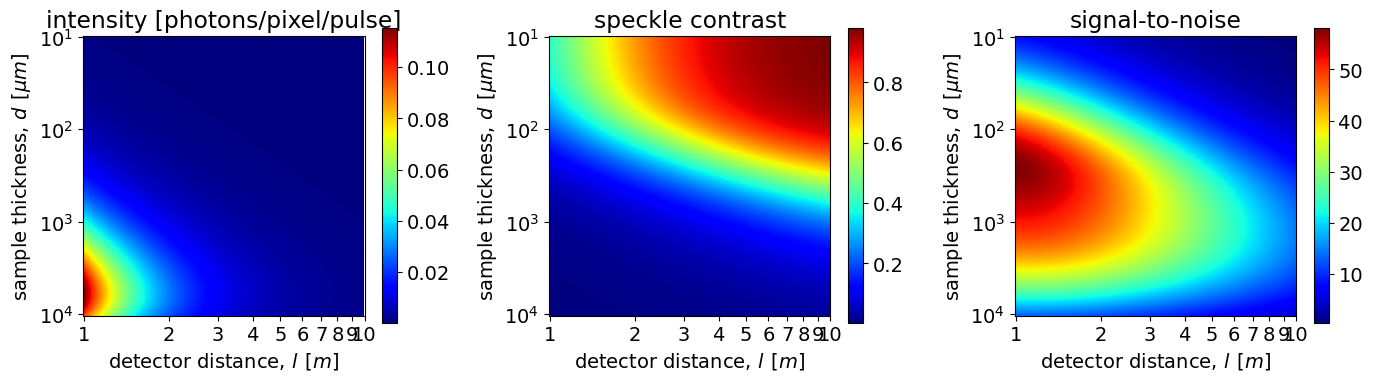

In [13]:
fig,ax = plt.subplots(1,3)
fig.set_figheight(3.8)
fig.set_figwidth(14.)

im = ax[0].imshow(inty_map, cmap='jet')
ax[0].set_xlabel('detector distance, '+r'$l \:\: [m]$')
ax[0].set_ylabel('sample thickness, '+r'$d \:\: [\mu m]$')
ax[0].set_title('intensity [photons/pixel/pulse]')

ax[0].set_xticks([100 * np.log10(x + 1) for x in range(10)])
ax[0].set_xticklabels(["{}".format(x + 1) for x in range(10)])
ax[0].set_yticks([33 * x for x in range(4)])
ax[0].set_yticklabels(["$10^{}$".format(x + 1) for x in range(4)])

fig.colorbar(im,ax=ax[0])


#speckle contrast
im = ax[1].imshow(beta_map_2,cmap='jet')
ax[1].set_xlabel('detector distance, '+r'$l \:\: [m]$')
ax[1].set_ylabel('sample thickness, '+r'$d \:\: [\mu m]$')
ax[1].set_title('speckle contrast')

ax[1].set_xticks([100 * np.log10(x + 1) for x in range(10)])
ax[1].set_xticklabels(["{}".format(x + 1) for x in range(10)])
ax[1].set_yticks([33 * x for x in range(4)])
ax[1].set_yticklabels(["$10^{}$".format(x + 1) for x in range(4)])

fig.colorbar(im,ax=ax[1])


#signal-to-noise ratio
N_shots = 1e5     # number of shots per condition
snr_map = inty_map * beta_map_2 * np.sqrt(N_shots) * np.sqrt(pixel_num_fit[np.newaxis, :])/(2*(1+beta_map_2))

im = ax[2].imshow(snr_map,cmap='jet')
ax[2].set_xlabel('detector distance, '+r'$l \:\: [m]$')
ax[2].set_ylabel('sample thickness, '+r'$d \:\: [\mu m]$')
ax[2].set_title('signal-to-noise')

ax[2].set_xticks([100 * np.log10(x + 1) for x in range(10)])
ax[2].set_xticklabels(["{}".format(x + 1) for x in range(10)])
ax[2].set_yticks([33 * x for x in range(4)])
ax[2].set_yticklabels(["$10^{}$".format(x + 1) for x in range(4)])

fig.colorbar(im,ax=ax[2])


plt.tight_layout()
plt.show()

In [14]:
det_idx = np.argmin(np.abs(distance_list - 1.6))
thickness_idx = np.argmin(np.abs(thickness_list - 800))

In [15]:
snr_map[thickness_idx, det_idx]

50.152815347830334